In [11]:
import pandas as pd
import numpy as np

%matplotlib inline

### Walmart Sales Data

For the independent practice, we will analyze the weekly sales data from Walmart over a two year period from 2010 to 2012.

The data is again separated by store and by department, but we will focus on analyzing one store for simplicity.

The data includes:

- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week


#### Loading the data and setting the DateTimeIndex

In [12]:
data = pd.read_csv('../../assets/dataset/train.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


#### Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [13]:
# Filter to store 1 sales and average over weeks
store1_sales = data[data.Store == 1][['Weekly_Sales']].resample('W', 'sum')
store1_sales.head()

/Users/bear/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  from ipykernel import kernelapp as app


,Weekly_Sales
Date,
2010-02-07,1643690.90
2010-02-14,1641957.44
2010-02-21,1611968.17
2010-02-28,1409727.59
2010-03-07,1554806.68


#### Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?

/Users/bear/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=3,center=False).mean()
  if __name__ == '__main__':


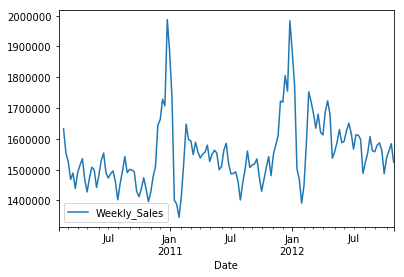

In [14]:
pd.rolling_mean(store1_sales[['Weekly_Sales']], 3).plot()

#### Compute the 1, 2, 52 autocorrelations for `Weekly_Sales` and/or create an autocorrelation plot.

In [15]:
print('Autocorrelation 1: ', store1_sales['Weekly_Sales'].autocorr(1))
print('Autocorrelation 3: ', store1_sales['Weekly_Sales'].autocorr(3))
print('Autocorrelation 52: ', store1_sales['Weekly_Sales'].autocorr(52))

('Autocorrelation 1: ', 0.30215827941131262)
('Autocorrelation 3: ', 0.059799235066717006)
('Autocorrelation 52: ', 0.89537602947770079)


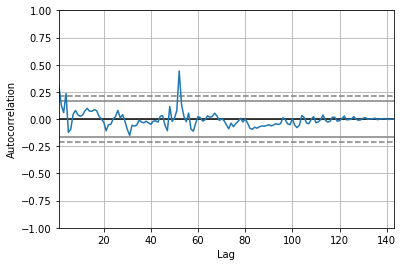

In [16]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(store1_sales['Weekly_Sales'])

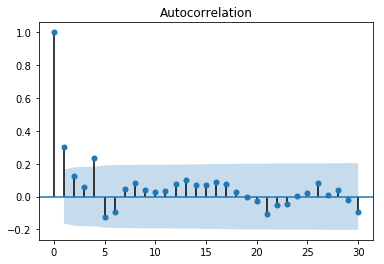

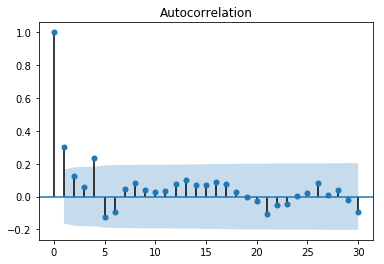

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(store1_sales['Weekly_Sales'], lags=30)

# Components 1 and 2 seem particularly useful for autoregression, perhaps up to 4
# In the plot above notice, spike at around 52 - implying a yearly pattern as well
# No random spikes, probably not much use for a moving average model

#### Split the weekly sales data in a training and test set - using 75% of the data for training

In [18]:
n = len(store1_sales.Weekly_Sales)

train = store1_sales.Weekly_Sales[:int(.75*n)]
test = store1_sales.Weekly_Sales[int(.75*n):]

#### Create an AR(1) model on the training data and compute the mean absolute error of the predictions.

In [19]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [26]:
model = sm.tsa.ARIMA(train, (1, 0, 0)).fit()

test.tail()

Date
2012-09-30    1437059.26
2012-10-07    1670785.97
2012-10-14    1573072.81
2012-10-21    1508068.77
2012-10-28    1493659.74
Freq: W-SUN, Name: Weekly_Sales, dtype: float64

In [28]:
model_ma1 = sm.tsa.ARIMA(train, (0, 0, 1)).fit()
predictions = model_ma1.predict(
    '2012-02-26',
    '2012-10-28',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model_ma1.summary()

('Mean absolute error: ', 82029.916293799062)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(0, 1)   Log Likelihood               -1435.704
Method:                       css-mle   S.D. of innovations         162519.051
Date:                Tue, 16 May 2017   AIC                           2877.409
Time:                        21:02:59   BIC                           2885.427
Sample:                    02-07-2010   HQIC                          2880.659
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.544e+06   1.96e+04     78.567      0.000    1.51e+06    1.58e+06
ma.L1.Weekly_Sales     0.2530      0.078      3.235      0.002       0.100       0.406
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -3.9533           +0.0000j            3.9533            0.5000
-----------------------------------------------------------------------------
"""

In [27]:
predictions = model.predict(
    '2012-02-26',
    '2012-10-28',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 81839.338631623992)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(1, 0)   Log Likelihood               -1434.663
Method:                       css-mle   S.D. of innovations         160916.939
Date:                Tue, 16 May 2017   AIC                           2875.327
Time:                        21:00:45   BIC                           2883.345
Sample:                    02-07-2010   HQIC                          2878.577
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.544e+06   2.26e+04     68.293      0.000     1.5e+06    1.59e+06
ar.L1.Weekly_Sales     0.3147      0.093      3.399      0.001       0.133       0.496
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1779           +0.0000j            3.1779            0.0000
-----------------------------------------------------------------------------
"""

#### Plot the residuals - where are their significant errors.

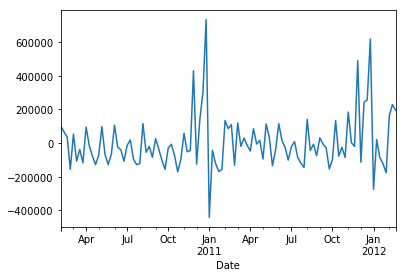

In [29]:
model.resid.plot()

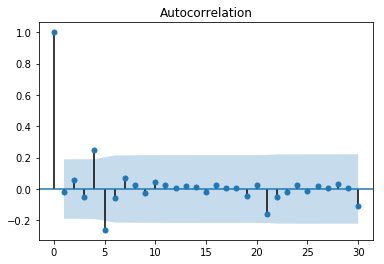

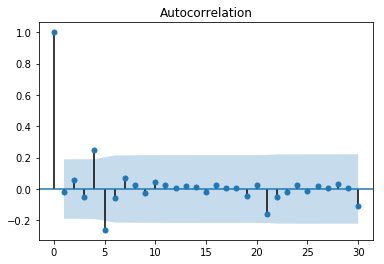

In [30]:
plot_acf(model.resid, lags=30)

#### Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set.

In [32]:
model = sm.tsa.ARIMA(train, (2, 0, 0)).fit()

predictions = model.predict(
    '2012-02-26',
    '2012-10-28',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 81203.234373150481)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 0)   Log Likelihood               -1434.482
Method:                       css-mle   S.D. of innovations         160638.038
Date:                Tue, 16 May 2017   AIC                           2876.963
Time:                        21:05:48   BIC                           2887.655
Sample:                    02-07-2010   HQIC                          2881.298
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.544e+06    2.4e+04     64.349      0.000     1.5e+06    1.59e+06
ar.L1.Weekly_Sales     0.2974      0.097      3.075      0.003       0.108       0.487
ar.L2.Weekly_Sales     0.0589      0.098      0.603      0.548      -0.132       0.250
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3080           +0.0000j            2.3080            0.0000
AR.2           -7.3587           +0.0000j            7.3587            0.5000
-----------------------------------------------------------------------------
"""

In [33]:
model = sm.tsa.ARIMA(train, (2, 0, 2)).fit()

predictions = model.predict(
    '2012-02-26',
    '2012-10-28',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 80502.761843172528)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 2)   Log Likelihood               -1425.781
Method:                       css-mle   S.D. of innovations         144113.438
Date:                Tue, 16 May 2017   AIC                           2863.563
Time:                        21:07:33   BIC                           2879.600
Sample:                    02-07-2010   HQIC                          2870.064
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.544e+06   1.92e+04     80.317      0.000    1.51e+06    1.58e+06
ar.L1.Weekly_Sales    -1.0397      0.090    -11.582      0.000      -1.216      -0.864
ar.L2.Weekly_Sales    -0.4700      0.087     -5.379      0.000      -0.641      -0.299
ma.L1.Weekly_Sales     1.4691      0.058     25.350      0.000       1.356       1.583
ma.L2.Weekly_Sales     0.9998      0.074     13.532      0.000       0.855       1.145
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1060           -0.9509j            1.4586           -0.3870
AR.2           -1.1060           +0.9509j            1.4586            0.3870
MA.1           -0.7347           -0.6785j            1.0001           -0.3813
MA.2           -0.7347           +0.6785j            1.0001            0.3813
-----------------------------------------------------------------------------
"""

#### Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance.

In [34]:
model = sm.tsa.ARIMA(train, (2, 1, 3)).fit()

predictions = model.predict(
    '2012-02-26',
    '2012-10-28',
    dynamic=False, 
    typ='levels'
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 77792.228525300947)


/Users/bear/anaconda/envs/py27/lib/python2.7/site-packages/statsmodels/base/model.py:504: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Weekly_Sales   No. Observations:                  106
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1413.622
Method:                       css-mle   S.D. of innovations         142940.624
Date:                Tue, 16 May 2017   AIC                           2841.244
Time:                        21:07:50   BIC                           2859.888
Sample:                    02-14-2010   HQIC                          2848.801
                         - 02-19-2012                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  577.2273    621.696      0.928      0.355    -641.274    1795.729
ar.L1.D.Weekly_Sales    -1.0483      0.090    -11.607      0.000      -1.225      -0.871
ar.L2.D.Weekly_Sales    -0.4786      0.088     -5.451      0.000      -0.651      -0.307
ma.L1.D.Weekly_Sales     0.4695      0.117      4.024      0.000       0.241       0.698
ma.L2.D.Weekly_Sales    -0.4694      0.154     -3.058      0.003      -0.770      -0.168
ma.L3.D.Weekly_Sales    -0.9998      0.124     -8.046      0.000      -1.243      -0.756
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0952           -0.9434j            1.4455           -0.3868
AR.2           -1.0952           +0.9434j            1.4455            0.3868
MA.1            1.0001           -0.0000j            1.0001           -0.0000
MA.2           -0.7348           -0.6784j            1.0000           -0.3813
MA.3           -0.7348           +0.6784j            1.0000            0.3813
-----------------------------------------------------------------------------
"""